# __Particle tracking__

### Problem statement

Once flow is computed on a DFN, one can compute the transport properties using a particle tracking approach. <br/>

<center>
<div>
<img src="https://gitlab.com/fractorylab/dfnlab/-/raw/master/Tutorials/img/particles.png" width="500"/>
</div>
<br>
Particles trajectories in a DFN
</center>

### Theorical background

Basic knowledge about advective transport is required.
<br>
We recall that particles velocities are constant inside the mesh triangles.

### What will you learn ?
- Apply transport boundary conditions (particles generation)
- Run particle tracking
- Compute transport indicators
- Access particles trajectories and information

### DFN.Lab model

The required module is __ParticlesTracking__.

In [1]:
import dfnlab.ParticlesTracking as dfnPTrack

_____________

### Solve flow on a DFN

The current tutorial is built on the same example as in the tutorial on steady-state flow. We create cubic domain, import previously generated DFN and mesh from file and apply properties and boundary conditions.

In [2]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.FlowBoundaryConditions as bc
import dfnlab.Mesh as mesh
import dfnlab.Flow as flow
import dfnlab.MaterialProperties as mat
import numpy as np
import os
system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=1.)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
dfn.load_disk_file(fnet,filename='sources/Ktest.disk')
system.build()
meshDFN = mesh.Mesh(system)
meshDFN.load("sources/MeshExamples/KTestFine/")
bc.FlowBoundaryCondition.setPermeameter(domain,10,np.array([0,0,1]))
mat.Transmissivities.setConstant(fnet,1)
flow_system = flow.solveDarcyProblem(meshDFN)

Linear system building 
Taking account of the boundary conditions
Linear System solving


We visualise the meshed DFN and the hydraulic head.

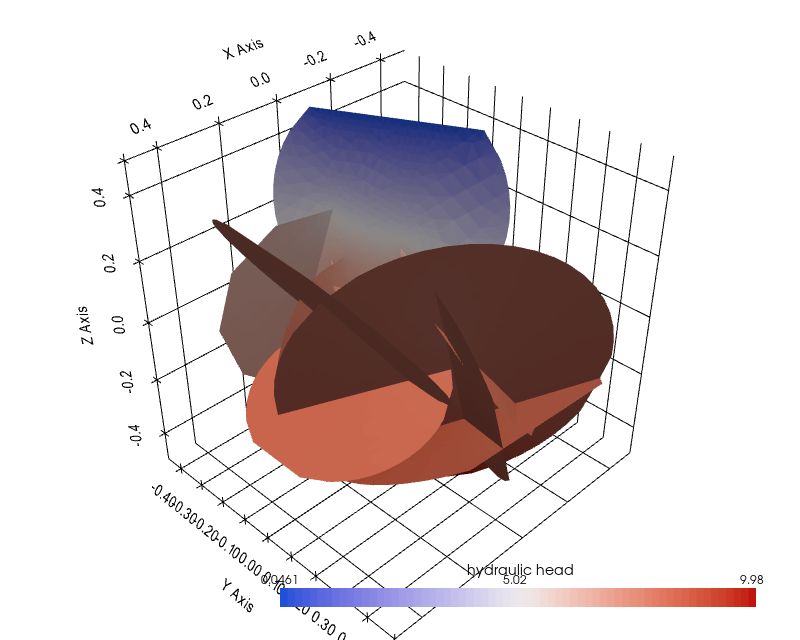

In [3]:
from sources.functions import plot_mesh
plot_mesh(meshDFN,flow_system.getHead(),"hydraulic head")

### Apply transport boundary conditions (particles generation)

First, we create an empty set of particles.

In [4]:
particlesSet =  dfnPTrack.ParticleSet(flow_system)

Then, we create a particle generator. Particles can be generated on any object (borders, wells, fracture intersections...). <br>In this example, the particles are generated on the domain bottom border.

In [5]:
generator = dfnPTrack.ParticlesGenerator(particlesSet)
generator.setSeed(1001)
generator.addObject(system.getDomain().getBorder(4));

The method _generate_ is used to create the desired number of particles in the particle set.

In [6]:
generator.generate(100)
print("Number of particles: {}".format(particlesSet.numParticles()))

Number of particles: 100


### Run particle tracking

By default, particles positions are only stored at intersections between fractures (to limit memory). 
<br> Next line must be executed to save positions at each mesh element.

In [7]:
particlesSet.saveAllPositions()

Then, you can run the particle tracking algorithm.
<br>

In [8]:
particlesSet.run()

Visualisation.

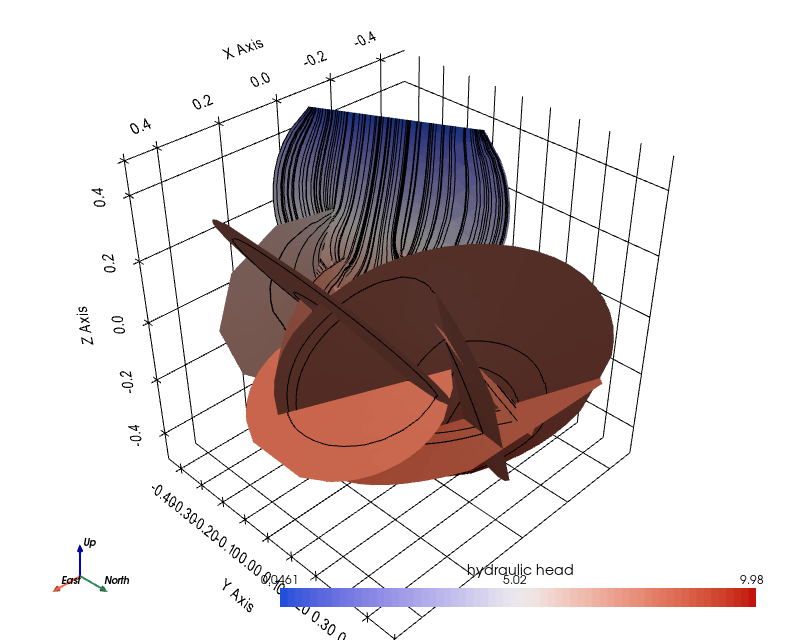

In [9]:
from sources.functions import plot_flow_particles
plot_flow_particles(meshDFN, particlesSet,flow_system.getHead(),"hydraulic head")

### Compute transport indicators

The access to transport indicators is similar to the access to flow indicators.

You have access to the main statistical indicator, concerning time of flights...

In [10]:
timeOfFlights = particlesSet.getIndicators("timeOfFlight")
timeOfFlightsStat = timeOfFlights.getStatisticalDistribution()

print("Minimum time of flight: {}".format(timeOfFlightsStat.getMinimum()))
print("Maximum time of flight: {}".format(timeOfFlightsStat.getMaximum()))
print("Mean time of flight: {}".format(timeOfFlightsStat.getMean()))
print("Median time of flight: {}".format(timeOfFlightsStat.getMedian()))
print("Standard deviation time of flight: {}".format(timeOfFlightsStat.getStandardDeviation()))
print("Variance time of flight: {}".format(timeOfFlightsStat.getVariance()))
print("Skewness time of flight: {}".format(timeOfFlightsStat.getSkewness()))
print("Kurtosis time of flight: {}".format(timeOfFlightsStat.getKurtosis()))

Minimum time of flight: 0.0015263733503003063
Maximum time of flight: 0.1599287441455961
Mean time of flight: 0.00478070463363042
Median time of flight: 0.002528320850836857
Standard deviation time of flight: 0.01583695447889965
Variance time of flight: 0.00025080912716673965
Skewness time of flight: 5.79531758664959e-06
Kurtosis time of flight: 3.3571469192497646e-09


... and length of flights.

In [11]:
lengthofFlights = particlesSet.getIndicators("lengthOfFlight")
lengthofFlightsStats = lengthofFlights.getStatisticalDistribution()

print("Minimum length of flight: {}".format(lengthofFlightsStats.getMinimum()))
print("Maximum length of flight: {}".format(lengthofFlightsStats.getMaximum()))
print("Mean length of flight: {}".format(lengthofFlightsStats.getMean()))
print("Median length of flight: {}".format(lengthofFlightsStats.getMedian()))
print("Standard deviation length of flight: {}".format(lengthofFlightsStats.getStandardDeviation()))
print("Variance length of flight: {}".format(lengthofFlightsStats.getVariance()))
print("Skewness length of flight: {}".format(lengthofFlightsStats.getSkewness()))
print("Kurtosis length of flight: {}".format(lengthofFlightsStats.getKurtosis()))

Minimum length of flight: 1.0532163212080603
Maximum length of flight: 3.137952077136905
Mean length of flight: 1.296350142845042
Median length of flight: 1.2473101588686781
Standard deviation length of flight: 0.24679698776321643
Variance length of flight: 0.060908753168997194
Skewness length of flight: 0.11891761490906635
Kurtosis length of flight: 1.3235316088513556


The computation of probability density function of the statistics is also available, and plotted below.

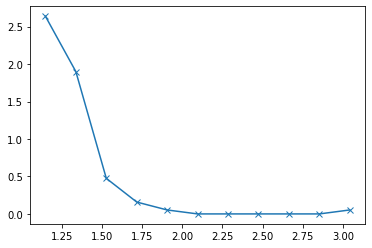

In [12]:
import matplotlib.pyplot as plt
lp,pdf = lengthofFlightsStats.getPDF()
plt.plot(lp,pdf,'-x');

### Access to particles

Particles can be accessed through a loop on the particle set:

In [13]:
for p in particlesSet:
    position = p.getPosition()

Or accessed directly using their index.

In [14]:
particle = particlesSet.getParticle(45)

You have access to the number of positions of a particle.

In [15]:
print("Number of positions of the particle: {}".format(particle.getNumberOfPositionInTrajectory()))

Number of positions of the particle: 107


Then, you have access to more information on each position, such as position, velocity, elements, extras, indicators ...

In [16]:
posList=[]
timeList=[]
for p in range(particle.getNumberOfPositionInTrajectory()):
    positionInfo = particle.getPositionInformation(p)
    posList.append(positionInfo.getPosition())
    timeList.append(positionInfo.getTime())
    
print("Last position and last time are : {} and {}".format(positionInfo.getPosition(),positionInfo.getTime()))

Last position and last time are : [-0.04887072 -0.35075703  0.5       ] and 0.002047058743473772


You can also access all positions of the particle through an iterator.

In [17]:
posList2=[]
for positionInfo in particle:
    posList2.append(positionInfo.getPosition())
    print(positionInfo.getPosition())

[-0.18712888  0.08740659 -0.5       ]
[-0.18218166  0.08082074 -0.48734387]
[-0.18054904  0.07893122 -0.48354334]
[-0.17426843  0.07265435 -0.4702372 ]
[-0.17180978  0.07131056 -0.46650343]
[-0.16547165  0.06572753 -0.45407085]
[-0.1626457   0.06429127 -0.44992274]
[-0.15962978  0.06220749 -0.44476579]
[-0.15215231  0.05661396 -0.4314141 ]
[-0.14833965  0.05321602 -0.42388302]
[-0.14247993  0.04879866 -0.41337493]
[-0.13931571  0.04545756 -0.40643435]
[-0.13383763  0.04065341 -0.39571702]
[-0.12927525  0.03540521 -0.3851389 ]
[-0.12663543  0.03261348 -0.37934282]
[-0.12619234  0.03211349 -0.37832835]
[-0.12105573  0.02497747 -0.36479284]
[-0.11989932  0.02335818 -0.36172869]
[-0.11522361  0.01848165 -0.35155294]
[-0.11104092  0.0141604  -0.34250461]
[-0.10682311  0.00958424 -0.33309062]
[-0.10670278  0.00945342 -0.33282169]
[-0.10046524  0.0025593  -0.31873198]
[-0.09399266 -0.00493336 -0.30366254]
[-0.09334492 -0.0056964  -0.30213696]
[-0.08739539 -0.01299564 -0.28773933]
[-0.08643053

All indicators and methods are listed in the documentation.